Import libraries and Loadcsv

In [44]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'sign-language-mnist:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3258%2F5337%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240518%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240518T091103Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4e64d9505fd6cc1dcd11d915ba212caeeb2d2a1fdb423cf090d942a01bfcaaa8f9671390809b6d5a6b582f732158fb6a3e71ca2e62b435927aad7341a037e3216e58698f4bdf95880dae64f7d168c81915985ee61bd31990ed5bd6e3396608517607f1f5f687b7bebd821d896f0060b1fe24f1a6e3133d20fac817688731c562ac51e9b80f1ba691202196ee072644eb5fb31cc7e6aa4b4f459585e1bb1983fe9ec70ca1de5dc164a7ca699c0f14c77f8f844bee4eae435ec9eecc3b24a0af7ba889da8273a90640064f1f161ee2f3b7b154d91aa9b501fefe844729eacc99ace6699e8bfd4649c67d7dc6546eb03e9f8389b402a166652355101cf9ecf5bc07'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 65633206 bytes downloaded
Downloaded and uncompressed: sign-language-mnist
Data source import complete.


In [45]:

import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sign-language-mnist/american_sign_language.PNG
/kaggle/input/sign-language-mnist/sign_mnist_test.csv
/kaggle/input/sign-language-mnist/sign_mnist_train.csv
/kaggle/input/sign-language-mnist/amer_sign3.png
/kaggle/input/sign-language-mnist/amer_sign2.png
/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv
/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv


In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau


In [47]:
train = pd.read_csv("../input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv")
test = pd.read_csv("../input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv")

In [49]:
test = pd.read_csv("../input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv")
y = test['label']


Data Summarization

In [50]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [51]:
train.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,...,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000
mean,12.318813,145.419377,148.500273,151.247714,153.546531,156.210891,158.411255,160.472154,162.339683,163.954799,...,141.104863,147.495611,153.325806,159.125332,161.969259,162.736696,162.906137,161.966454,161.137898,159.824731
std,7.287552,41.358555,39.942152,39.056286,38.595247,37.111165,36.125579,35.016392,33.661998,32.651607,...,63.751194,65.512894,64.427412,63.708507,63.738316,63.444008,63.509210,63.298721,63.610415,64.396846
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,121.000000,126.000000,130.000000,133.000000,137.000000,140.000000,142.000000,144.000000,146.000000,...,92.000000,96.000000,103.000000,112.000000,120.000000,125.000000,128.000000,128.000000,128.000000,125.500000
50%,13.000000,150.000000,153.000000,156.000000,158.000000,160.000000,162.000000,164.000000,165.000000,166.000000,...,144.000000,162.000000,172.000000,180.000000,183.000000,184.000000,184.000000,182.000000,182.000000,182.000000
75%,19.000000,174.000000,176.000000,178.000000,179.000000,181.000000,182.000000,183.000000,184.000000,185.000000,...,196.000000,202.000000,205.000000,207.000000,208.000000,207.000000,207.000000,206.000000,204.000000,204.000000
max,24.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


Data Cleaning

In [52]:

train.cov()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
label,53.108415,-41.072806,-37.838635,-32.223255,-29.279696,-26.280576,-25.432713,-22.139680,-18.371212,-16.533123,...,-12.245788,-27.757670,-38.999737,-37.590917,-28.052376,-21.850925,-18.406951,-14.218998,-9.980004,-2.862893
pixel1,-41.072806,1710.530097,1620.439020,1556.318162,1509.816903,1423.454863,1349.865805,1271.939558,1193.407987,1122.070680,...,653.864632,666.346381,710.061546,741.054962,692.816928,671.602669,641.084459,576.374745,489.503906,456.432908
pixel2,-37.838635,1620.439020,1595.375528,1525.681272,1468.723771,1402.268792,1333.699731,1257.798498,1183.922760,1117.340309,...,642.623760,654.507277,689.125485,716.408886,677.222562,658.007011,631.902972,574.393267,493.075980,453.132815
pixel3,-32.223255,1556.318162,1525.681272,1525.393469,1475.063599,1389.007749,1340.352883,1275.454574,1203.876550,1137.670664,...,648.778059,651.860179,679.151898,686.617601,641.762660,623.385763,600.280337,534.246964,454.853178,427.268631
pixel4,-29.279696,1509.816903,1468.723771,1475.063599,1489.593076,1401.667247,1342.486855,1290.292282,1225.216837,1158.462309,...,629.602045,633.097995,661.072131,671.183958,627.156344,607.689694,586.713681,528.660099,447.228631,413.374441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pixel780,-21.850925,671.602669,658.007011,623.385763,607.689694,586.774843,557.149339,530.519859,506.279215,492.126693,...,2112.556933,2587.340088,3009.955644,3439.682197,3848.888642,4025.142186,3855.684799,3636.917954,3457.486300,3301.599220
pixel781,-18.406951,641.084459,631.902972,600.280337,586.713681,565.224247,535.264909,513.726078,491.952370,474.387285,...,1971.870155,2416.528637,2813.433183,3236.796896,3588.442915,3855.684799,4033.419724,3843.189938,3623.305433,3487.670006
pixel782,-14.218998,576.374745,574.393267,534.246964,528.660099,512.536651,486.715115,471.326140,453.083152,429.920207,...,1863.735724,2260.224101,2649.942889,3065.074030,3419.073202,3636.917954,3843.189938,4006.728058,3860.638414,3671.717876
pixel783,-9.980004,489.503906,493.075980,454.853178,447.228631,441.069664,427.260035,408.654783,391.092371,387.188393,...,1745.900123,2129.901130,2493.410341,2878.564052,3230.785073,3457.486300,3623.305433,3860.638414,4046.284910,3934.773715


In [53]:
train.skew()

label      -0.095249
pixel1     -0.558068
pixel2     -0.577706
pixel3     -0.645864
pixel4     -0.772380
              ...   
pixel780   -0.916529
pixel781   -0.954015
pixel782   -0.947602
pixel783   -0.952318
pixel784   -0.930335
Length: 785, dtype: float64

In [54]:
train.isnull()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
27451,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
27452,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
27453,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Data exlporation

In [55]:
train.tail()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
27450,13,189,189,190,190,192,193,193,193,193,...,132,165,99,77,52,200,234,200,222,225
27451,23,151,154,157,158,160,161,163,164,166,...,198,198,198,198,198,196,195,195,195,194
27452,18,174,174,174,174,174,175,175,174,173,...,121,196,209,208,206,204,203,202,200,200
27453,17,177,181,184,185,187,189,190,191,191,...,119,56,27,58,102,79,47,64,87,93
27454,23,179,180,180,180,182,181,182,183,182,...,108,132,170,194,214,203,197,205,209,215


In [56]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 164.4 MB


In [57]:
train.dtypes

label       int64
pixel1      int64
pixel2      int64
pixel3      int64
pixel4      int64
            ...  
pixel780    int64
pixel781    int64
pixel782    int64
pixel783    int64
pixel784    int64
Length: 785, dtype: object

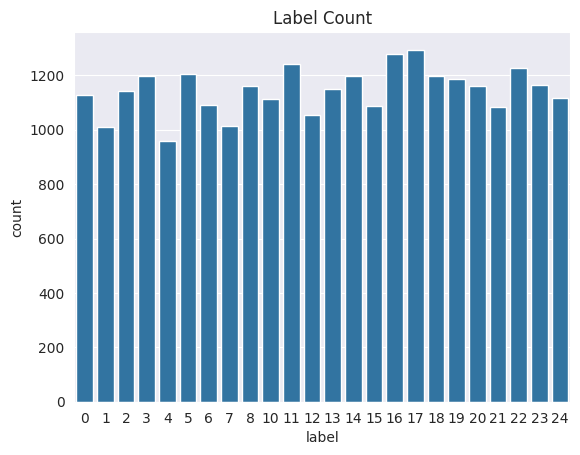

In [58]:
sns.set_style("darkgrid")
sns.countplot(x="label", data=train)
plt.title("Label Count")
plt.show()

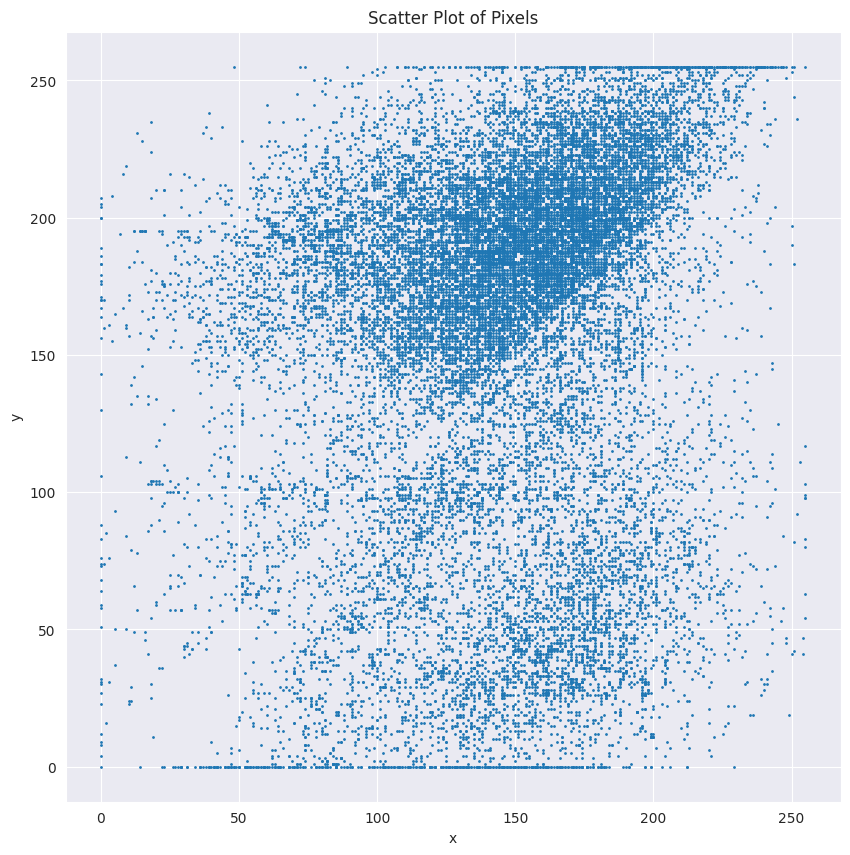

In [59]:
plt.figure(figsize=(10, 10))
plt.scatter(train['pixel1'], train['pixel784'], s=1)
plt.title("Scatter Plot of Pixels")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Data visualization and preprocessing

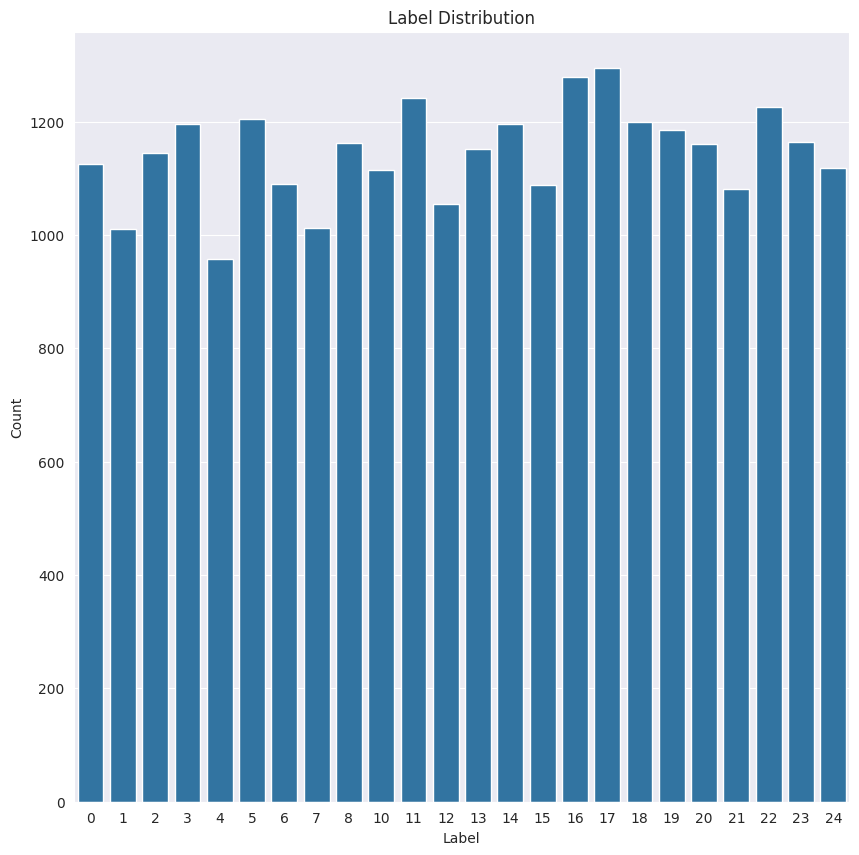

In [60]:
plt.figure(figsize=(10, 10))
sns.set_style("darkgrid")
sns.countplot(x="label", data=train)
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

In [61]:
y_train = train['label']
y_test = test['label']
del train['label']
del test['label']

In [62]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [63]:
x_train = train.values
x_test = test.values

In [64]:
print(train.columns)

Index(['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7',
       'pixel8', 'pixel9', 'pixel10',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=784)


Data transformation

Normalize and Reshaping data

In [65]:

x_train = x_train / 255
x_test = x_test / 255

In [66]:
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

In [67]:
#x_train_mean = np.mean(x_train, axis=(0,1,2))
#x_train = (x_train - x_train_mean) / x_train_std
#x_test = (x_test - x_train_mean) / x_train_std

Show image

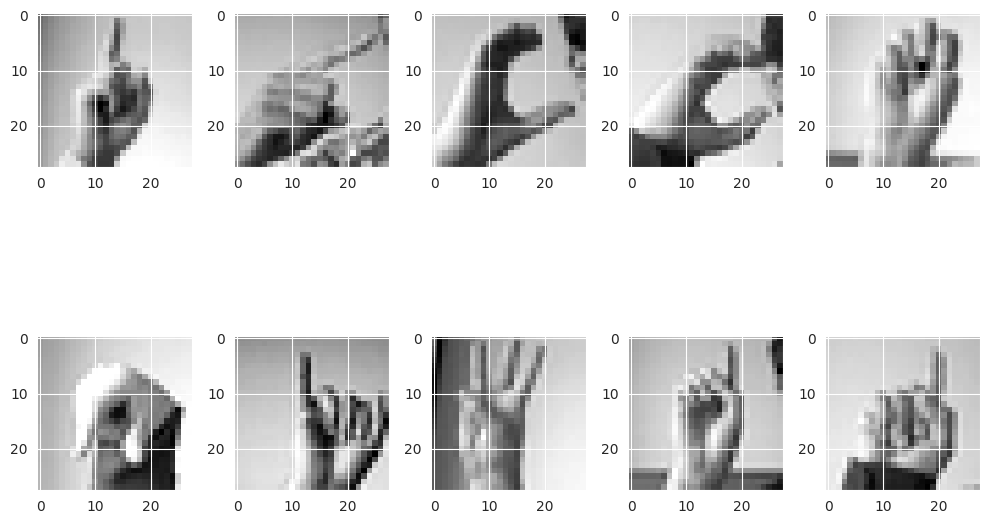

In [68]:
f, ax = plt.subplots(2,5)
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()

In [69]:

datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)


datagen.fit(x_train)

In [70]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [71]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 75)        750       
                                                                 
 batch_normalization_3 (Bat  (None, 28, 28, 75)        300       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 75)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_4 (Bat  (None, 14, 14, 50)       

In [72]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 128) ,epochs = 20 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction])

Epoch 1/20
215/215 [==============================] - 16s 61ms/step - loss: 1.0218 - accuracy: 0.6830 - val_loss: 3.5466 - val_accuracy: 0.1757 - lr: 0.0010
Epoch 2/20
215/215 [==============================] - 16s 76ms/step - loss: 0.1871 - accuracy: 0.9384 - val_loss: 1.4707 - val_accuracy: 0.5878 - lr: 0.0010
Epoch 3/20
215/215 [==============================] - 14s 66ms/step - loss: 0.0960 - accuracy: 0.9685 - val_loss: 0.0902 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 4/20
215/215 [==============================] - 12s 57ms/step - loss: 0.0593 - accuracy: 0.9814 - val_loss: 0.0395 - val_accuracy: 0.9838 - lr: 0.0010
Epoch 5/20
215/215 [==============================] - 13s 60ms/step - loss: 0.0443 - accuracy: 0.9858 - val_loss: 0.0189 - val_accuracy: 0.9948 - lr: 0.0010
Epoch 6/20
215/215 [==============================] - 13s 60ms/step - loss: 0.0360 - accuracy: 0.9885 - val_loss: 0.0968 - val_accuracy: 0.9590 - lr: 0.0010
Epoch 7/20
214/215 [============================>.] - ETA:

In [73]:
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

225/225 [==============================] - 1s 3ms/step - loss: 7.4870e-04 - accuracy: 1.0000
Accuracy of the model is -  100.0 %


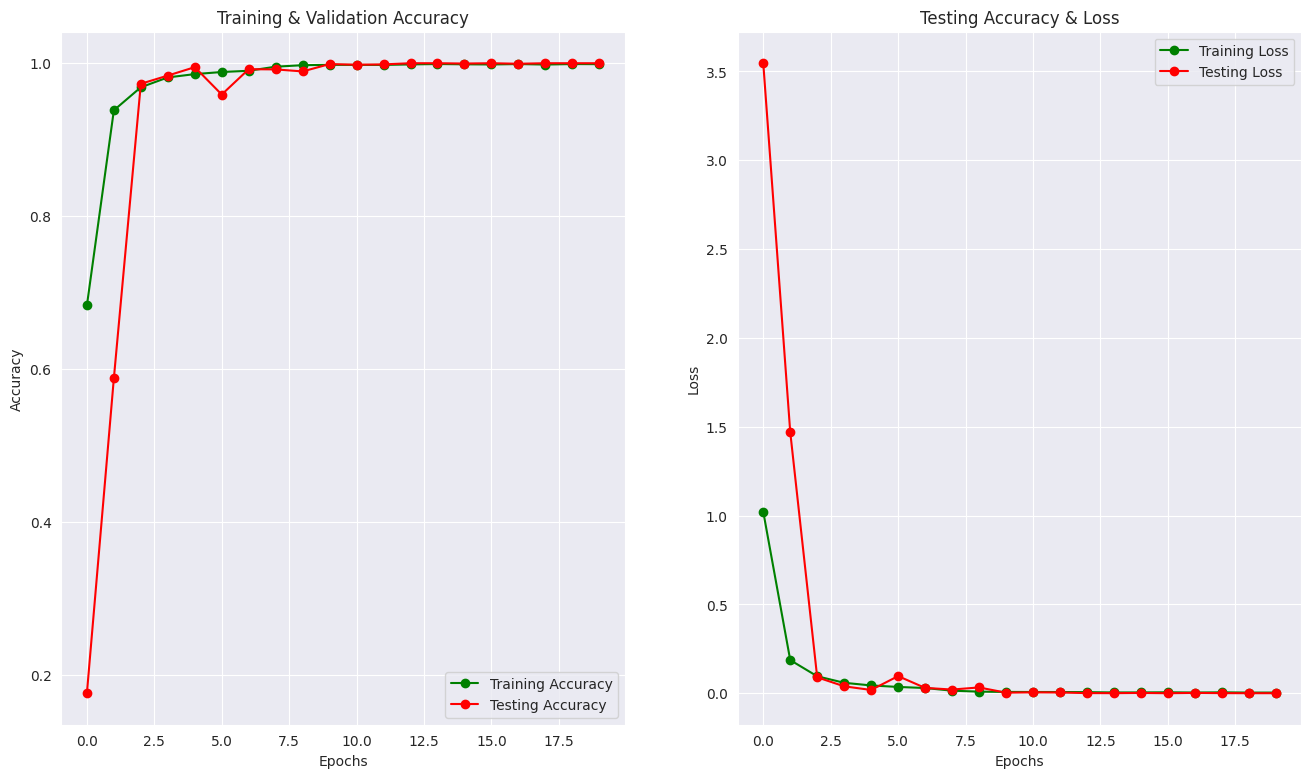

In [74]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [75]:
predictions_proba = model.predict(x_test)
predictions = np.argmax(predictions_proba, axis=1)
for i in range(len(predictions)):
    if(predictions_proba[i][9] >= 0.5 or predictions_proba[i][10] >= 0.5):
        predictions[i] += 1
print(predictions[:5])

225/225 [==============================] - 1s 2ms/step
[ 6  5 10  0  3]


In [76]:
classes = ["Class " + str(i) for i in range(25) if i != 9]
print(classification_report(y, predictions, target_names = classes))

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       331
     Class 1       1.00      1.00      1.00       432
     Class 2       1.00      1.00      1.00       310
     Class 3       1.00      1.00      1.00       245
     Class 4       1.00      1.00      1.00       498
     Class 5       1.00      1.00      1.00       247
     Class 6       1.00      1.00      1.00       348
     Class 7       1.00      1.00      1.00       436
     Class 8       1.00      1.00      1.00       288
    Class 10       1.00      1.00      1.00       331
    Class 11       0.35      1.00      0.51       209
    Class 12       0.00      0.00      0.00       394
    Class 13       0.00      0.00      0.00       291
    Class 14       0.00      0.00      0.00       246
    Class 15       0.00      0.00      0.00       347
    Class 16       0.00      0.00      0.00       164
    Class 17       0.00      0.00      0.00       144
    Class 18       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [77]:
cm = confusion_matrix(y,predictions)

In [78]:
cm = pd.DataFrame(cm , index = [i for i in range(25) if i != 9] , columns = [i for i in range(25) if i != 9])

<Axes: >

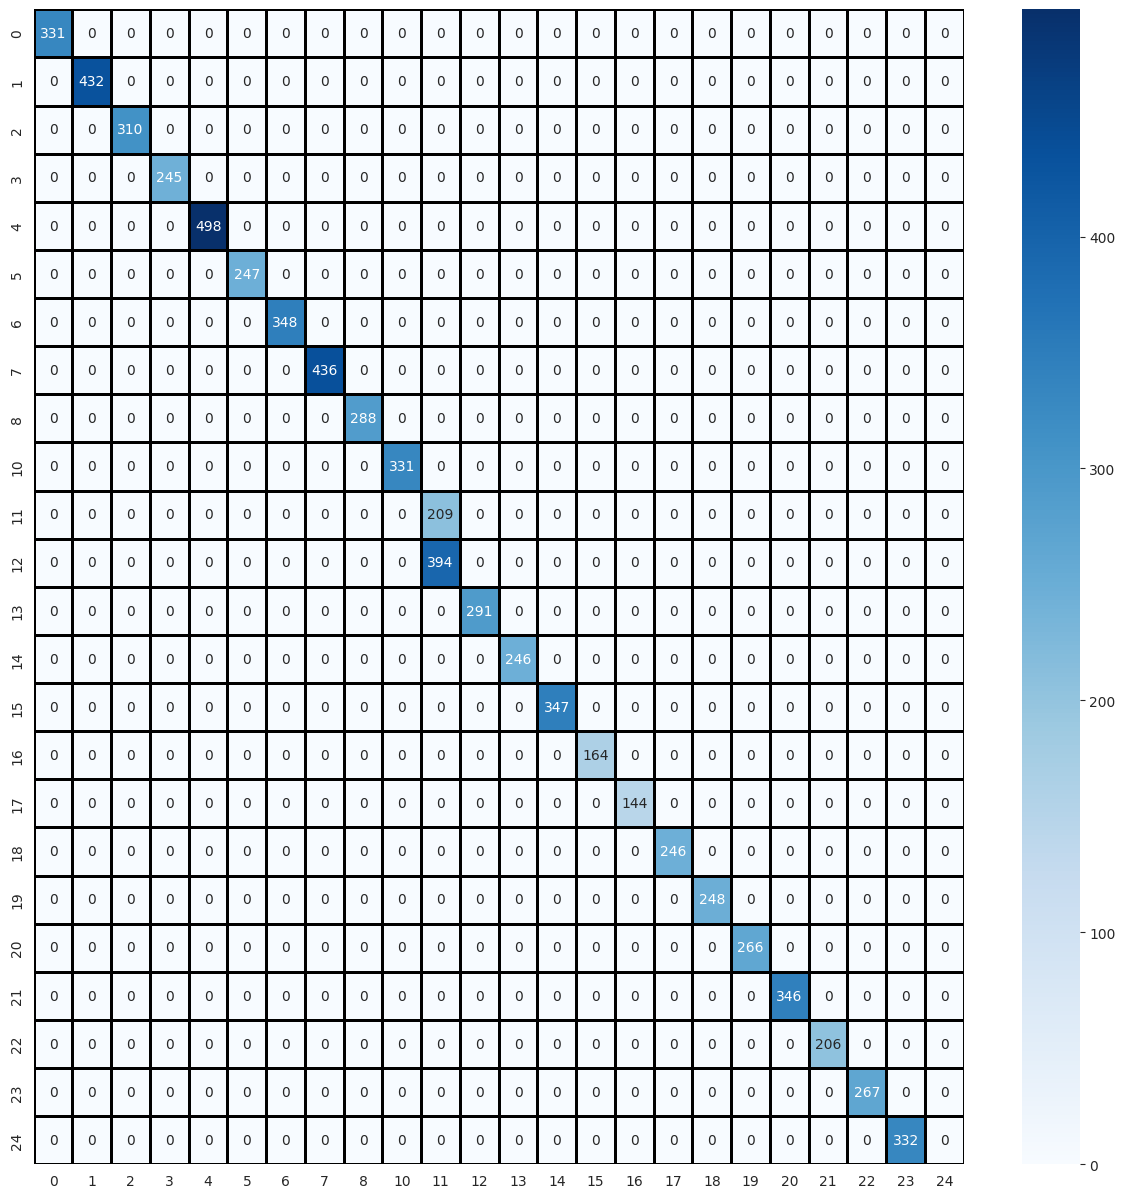

In [79]:
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [80]:
correct = np.nonzero(predictions == y)[0]


<ipython-input-81-65d3d49c5c14>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


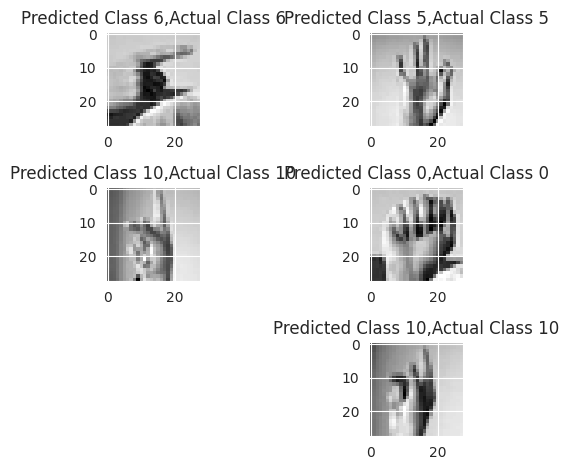

In [81]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.imshow(x_test[c].reshape(28,28), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y[c]))
    plt.tight_layout()
    i += 1

In [88]:
from tensorflow.keras.models import load_model
model.save('/content/drive/MyDrive/Colab Notebooks/Saved Model/Fingerspelling.hdf5')